# Second Project

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from code import data_preparation as dp
from code import visualizations as viz
import matplotlib.pyplot as plt
%matplotlib inline

## Initial Data Preparation

In [2]:
data = pd.read_csv('data/kc_house_data.csv')

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Since clients seeking recommendations cannot control where there property is, increase their or their neighbor's lot sizes, or travel back in time to build their house in a different year, we will drop these and similar variables from the data, along with irrelevant columns for analysis such as ID number.

In [5]:
irrelevant = ['id', 'date', 'sqft_lot', 'waterfront', 'view', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
relevant = data.drop(columns=irrelevant)

In [6]:
relevant.head()

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,sqft_basement,yr_renovated
0,221900.0,3,1.00,1180,1.0,Average,7 Average,1180,0.0,0.0
1,538000.0,3,2.25,2570,2.0,Average,7 Average,2170,400.0,1991.0
2,180000.0,2,1.00,770,1.0,Average,6 Low Average,770,0.0,NaN
3,604000.0,4,3.00,1960,1.0,Very Good,7 Average,1050,910.0,0.0
4,510000.0,3,2.00,1680,1.0,Average,8 Good,1680,0.0,0.0


### Dealing with Missing Values

#### *Missing Renovation Year Data*

We can see there are 3842 missing values about what year renovations we done, and a large number of zero values as well.

In [7]:
relevant['yr_renovated'].isna().sum()

3842

In [8]:
relevant['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

We will add a column indicating which values are missing and assume that NaN values are 0 values and represent no renovation. We will also bin the renovations into three categories: "not_renovated", "new_renovations", "old_renovations". We will define new renovations as ones that have been done in the past 10 years. We will then one-hot encode it so it can be used in a regression.

In [9]:
relevant['yr_ren_miss'] = dp.missing_indicator(relevant, 'yr_renovated')

In [10]:
relevant['yr_renovated'] = dp.impute_values(relevant, 'yr_renovated', type='median')

In [11]:
relevant['yr_renovated'].isna().sum()

0

In [12]:
def find_old_new(x, threshold=10):
    if x > (2020-threshold):
        return "new_ren"
    elif x == 0:
        return "not_ren"
    else:
        return "old_ren"

In [13]:
relevant['yr_renovated'] = relevant['yr_renovated'].apply(find_old_new)

In [14]:
cat, encode = dp.one_hot_encode(relevant, 'yr_renovated')

In [15]:
relevant[cat] = encode 

In [16]:
#One column dropped to avoid dummy variable trap
clean = relevant.drop(columns=['yr_renovated', 'not_ren'])

In [17]:
clean.head()

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,sqft_basement,yr_ren_miss,new_ren,old_ren
0,221900.0,3,1.00,1180,1.0,Average,7 Average,1180,0.0,False,0.0,0.0
1,538000.0,3,2.25,2570,2.0,Average,7 Average,2170,400.0,False,0.0,1.0
2,180000.0,2,1.00,770,1.0,Average,6 Low Average,770,0.0,True,0.0,0.0
3,604000.0,4,3.00,1960,1.0,Very Good,7 Average,1050,910.0,False,0.0,0.0
4,510000.0,3,2.00,1680,1.0,Average,8 Good,1680,0.0,False,0.0,0.0


As we can see we have dealt with all the NaN values.

In [18]:
clean.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
floors           0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_ren_miss      0
new_ren          0
old_ren          0
dtype: int64

### Dealing with Non-Numerical Data

In order to make a model we need to transform categorical data into numerical data. As we can see the condition, grade, and sqft_basement columns are objects, and will have to be transformed.

In [19]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   floors         21597 non-null  float64
 5   condition      21597 non-null  object 
 6   grade          21597 non-null  object 
 7   sqft_above     21597 non-null  int64  
 8   sqft_basement  21597 non-null  object 
 9   yr_ren_miss    21597 non-null  bool   
 10  new_ren        21597 non-null  float64
 11  old_ren        21597 non-null  float64
dtypes: bool(1), float64(5), int64(3), object(3)
memory usage: 1.8+ MB


#### *Dealing with Grade Column*

As we can see the grade column does include numerical ratings along with a short description of what they mean. 

In [20]:
clean['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

To begin we will just use the raw number in our model and may one-hot encode it if it optimizes the model.

In [21]:
clean['grade'] = clean['grade'].map(lambda x: int(x.split()[0]))

In [22]:
clean['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

#### *Dealing with Condition Column*

The condition column contains no interger ranks like the grade column.

In [23]:
clean['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

We could translate the ratings into a 1-5 scale, but we will just skip to one-hot encoding them.

In [24]:
cats, encode = dp.one_hot_encode(clean, 'condition')

In [25]:
labels = []
for cat in cats:
    labels.append('cond_'+cat)
labels

['cond_Average', 'cond_Fair', 'cond_Good', 'cond_Poor', 'cond_Very Good']

In [26]:
clean[labels]=encode

In [27]:
#One column dropped to avoid dummy variable trap
clean = clean.drop(columns=['condition', 'cond_Poor'])

In [28]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21597 non-null  float64
 1   bedrooms        21597 non-null  int64  
 2   bathrooms       21597 non-null  float64
 3   sqft_living     21597 non-null  int64  
 4   floors          21597 non-null  float64
 5   grade           21597 non-null  int64  
 6   sqft_above      21597 non-null  int64  
 7   sqft_basement   21597 non-null  object 
 8   yr_ren_miss     21597 non-null  bool   
 9   new_ren         21597 non-null  float64
 10  old_ren         21597 non-null  float64
 11  cond_Average    21597 non-null  float64
 12  cond_Fair       21597 non-null  float64
 13  cond_Good       21597 non-null  float64
 14  cond_Very Good  21597 non-null  float64
dtypes: bool(1), float64(9), int64(4), object(1)
memory usage: 2.3+ MB


#### *Dealing with Sqft Basement Column*

As we can see, there are many 0 values along with some hidden missing values that were input as '?'.

In [29]:
clean['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1880.0        1
1816.0        1
506.0         1
2600.0        1
2310.0        1
Name: sqft_basement, Length: 304, dtype: int64

We will make a column marking the missing values and replace them with the median value.

In [30]:
clean['sqft_basement'].replace('?', np.nan, inplace=True)
clean['sqft_base_miss'] = dp.missing_indicator(clean, 'sqft_basement')

In [31]:
clean['sqft_basement'] = dp.impute_values(clean,'sqft_basement', type='median')

In [32]:
clean['sqft_basement'].value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

Lastly we will convert the boolean value of the yr_renovated_missing column to an int.

In [33]:
clean[["yr_ren_miss","sqft_base_miss"]] = clean[["yr_ren_miss","sqft_base_miss"]].astype(int)

In [34]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21597 non-null  float64
 1   bedrooms        21597 non-null  int64  
 2   bathrooms       21597 non-null  float64
 3   sqft_living     21597 non-null  int64  
 4   floors          21597 non-null  float64
 5   grade           21597 non-null  int64  
 6   sqft_above      21597 non-null  int64  
 7   sqft_basement   21597 non-null  float64
 8   yr_ren_miss     21597 non-null  int32  
 9   new_ren         21597 non-null  float64
 10  old_ren         21597 non-null  float64
 11  cond_Average    21597 non-null  float64
 12  cond_Fair       21597 non-null  float64
 13  cond_Good       21597 non-null  float64
 14  cond_Very Good  21597 non-null  float64
 15  sqft_base_miss  21597 non-null  int32  
dtypes: float64(10), int32(2), int64(4)
memory usage: 2.5 MB


In [35]:
clean.head()

,price,bedrooms,bathrooms,sqft_living,floors,grade,sqft_above,sqft_basement,yr_ren_miss,new_ren,old_ren,cond_Average,cond_Fair,cond_Good,cond_Very Good,sqft_base_miss
0,221900.0,3,1.00,1180,1.0,7,1180,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,538000.0,3,2.25,2570,2.0,7,2170,400.0,0,0.0,1.0,1.0,0.0,0.0,0.0,0
2,180000.0,2,1.00,770,1.0,6,770,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0
3,604000.0,4,3.00,1960,1.0,7,1050,910.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,510000.0,3,2.00,1680,1.0,8,1680,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0


## Making a Base Model

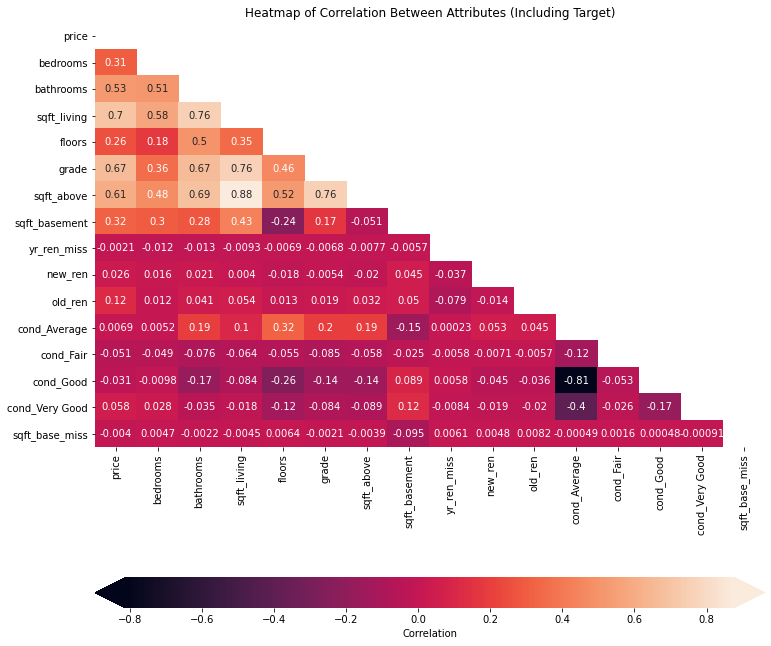

In [36]:
viz.create_heatmap(clean)

In our initial model we will only the top 3 variables most correlated with our target variable, price. So we will use sqft_living, grade and sqft_above to make a model.

In [37]:
X_train = clean.drop(columns='price')
y_train = clean['price']
baseline_model = LinearRegression()
base_val = dp.cross_val(baseline_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.5693464074325324
Validation score: 0.5741428262858914


As we can see, these varibles only explain about 57% of the variance in price in our data as it stands.

## Improving the Model

Two things that may be throwing off our model are the possibility that variables aren't normally distributed and are on very different scales.

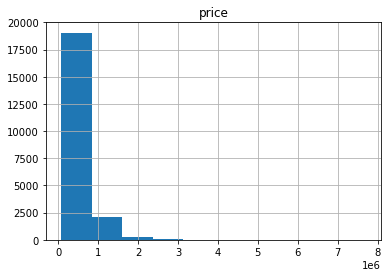

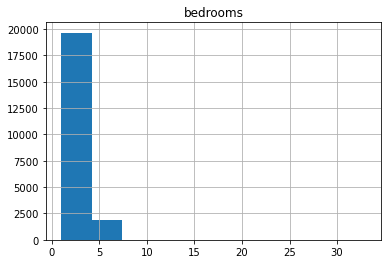

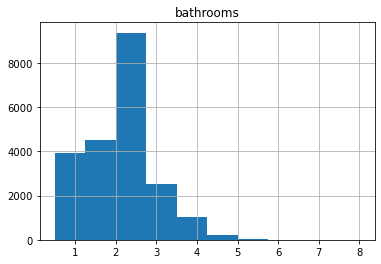

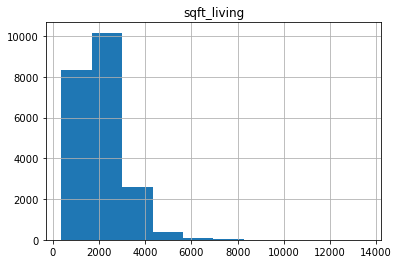

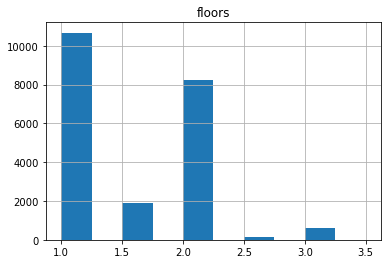

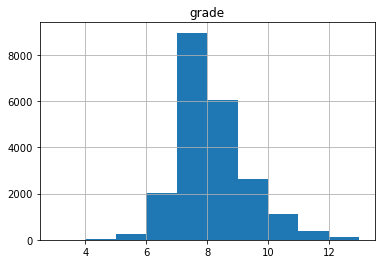

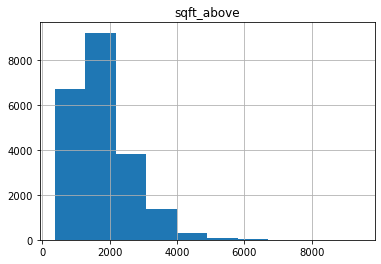

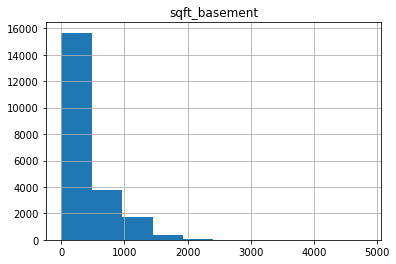

In [38]:
nonbool_columns = ['price','bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above','sqft_basement']
for column in nonbool_columns:
    clean[column].hist()
    plt.title(column)
    plt.show()

In [39]:
normalized = dp.log_normalize(clean, nonbool_columns, plus_1 = True)

In [40]:
normalized.head()

,price,bedrooms,bathrooms,sqft_living,floors,grade,sqft_above,sqft_basement
0,-1.402030,-0.320358,-1.644179,-1.125590,-0.947109,-0.531776,-0.753642,-0.785207
1,0.279944,-0.320358,0.290982,0.709433,0.988631,-0.531776,0.672641,1.112348
2,-1.799470,-1.687555,-1.644179,-2.131467,-0.947109,-1.543286,-1.752625,-0.785207
3,0.499709,0.740121,1.118601,0.070563,-0.947109,-0.531776,-1.026843,1.372126
4,0.178437,-0.320358,-0.028056,-0.292854,-0.947109,0.360438,0.073387,-0.785207


In [41]:
bool_df = clean.drop(columns=nonbool_columns)
normalized = pd.concat([normalized, bool_df], axis =1)
normalized.head()

,price,bedrooms,bathrooms,sqft_living,floors,grade,sqft_above,sqft_basement,yr_ren_miss,new_ren,old_ren,cond_Average,cond_Fair,cond_Good,cond_Very Good,sqft_base_miss
0,-1.402030,-0.320358,-1.644179,-1.125590,-0.947109,-0.531776,-0.753642,-0.785207,0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,0.279944,-0.320358,0.290982,0.709433,0.988631,-0.531776,0.672641,1.112348,0,0.0,1.0,1.0,0.0,0.0,0.0,0
2,-1.799470,-1.687555,-1.644179,-2.131467,-0.947109,-1.543286,-1.752625,-0.785207,1,0.0,0.0,1.0,0.0,0.0,0.0,0
3,0.499709,0.740121,1.118601,0.070563,-0.947109,-0.531776,-1.026843,1.372126,0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0.178437,-0.320358,-0.028056,-0.292854,-0.947109,0.360438,0.073387,-0.785207,0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [42]:
norm_model = LinearRegression()
X_train = normalized.drop(columns='price')
y_train = normalized['price']
normalized_model = LinearRegression()
norm_val = dp.cross_val(norm_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.5782678260184224
Validation score: 0.5833178317074601


In [43]:
norm_model.fit(X_train, y_train)
norm_model.score(X_train, y_train)

0.5797563506016312

In [44]:
np.arange(y_train.min(), y_train.max())

array([-3.38764677, -2.38764677, -1.38764677, -0.38764677,  0.61235323,
        1.61235323,  2.61235323,  3.61235323,  4.61235323])

In [45]:
preds = norm_model.predict(X_train)

In [46]:
np.arange(preds.min(), preds.max())

array([-3.20551946, -2.20551946, -1.20551946, -0.20551946,  0.79448054,
        1.79448054,  2.79448054,  3.79448054])

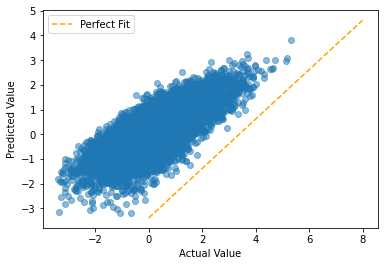

In [47]:
viz.linearity_graph(norm_model, X_train, y_train)